<a href="https://colab.research.google.com/github/Pafistino/innopolis.pafistino/blob/main/Lobanova_diplom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Введение:
*COVID-19 - это вызывающий заболевание штамм коронавируса, появившийся в декабре 2019 года и приведший к продолжающейся глобальной пандемии. Возможность предвидеть путь пандемии имеет решающее значение. Это важно для того, чтобы определить, как бороться, и отследить его распространение.*


# Цель исследования:
 Определить темп роста заболеваемости и смертности от инфекции в определенном временном промежутке на примере изучаемой страны - США, также спрогнозировать темп роста заболеваемости и летальности по причине COVID-19. 

#Задачи: 
- провести анализ данных о распространении COVID19 в США;
- выявить взаимосвязи между ключевыми событиями в данных в США;
- построить прогноз распространения пандемии COVID19 в США.

#Гипотеза:
В первые месяцы возникновения пандемии, динамика новых случаев заболеваний и смертности в США  будет расти, с принятием новых и эффективных мер профилактики и лечения, выйдет на плато, после чего будет динамика к снижению заболеваний и смертности от COVID-19.

Импортируем все необходимые библиотеки, метрики и модели:


In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 28.0 MB/s 
     |████████████████████████████████| 9.8 MB 59.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
!pip install fbprophet

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX       
from statsmodels.tsa.seasonal import seasonal_decompose      
from pmdarima import auto_arima                             
from fbprophet import Prophet                               
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse

Загружаем датасет по Covid-19

In [7]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
df = pd.read_csv(url)

Просматриваем выгрузку на примере одной, первой строки:

In [8]:
df.head(1)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients,icu_patients_per_million,hosp_patients,hosp_patients_per_million,weekly_icu_admissions,weekly_icu_admissions_per_million,weekly_hosp_admissions,weekly_hosp_admissions_per_million,new_tests,total_tests,total_tests_per_thousand,new_tests_per_thousand,new_tests_smoothed,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,tests_units,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,0.126,0.126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.33,39835428.0,54.422,18.6,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


#Рассмотрение данных:
Мы выбрали следующие данные для рассмотрения:
1. total_cases - накопительный итогом кол-во новых случаев заболеваний

2.  new_cases - новые случаи заболеваний за день

3. total_deaths - накопительный итогом кол-во смертей

4. new_deaths - новые случаи смертей за день


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149939 entries, 0 to 149938
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    149939 non-null  object 
 1   continent                                   140893 non-null  object 
 2   location                                    149939 non-null  object 
 3   date                                        149939 non-null  object 
 4   total_cases                                 147330 non-null  float64
 5   new_cases                                   147298 non-null  float64
 6   new_cases_smoothed                          146179 non-null  float64
 7   total_deaths                                130270 non-null  float64
 8   new_deaths                                  130438 non-null  float64
 9   new_deaths_smoothed                         146179 non-null  float64
 

Выберем страну из списка всех стран:

In [10]:
df.location.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Asia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethi

Мы выбрали США, т.к.:
1. Это страна с большим числом жителей (более 100 млн.) в отличие от европейских стран и статистическая выборка больше;
2. Статистика развитой страны имеет стандарты для сбора и обработки информации.

df.location == United States

In [11]:
df_new = df[df.location == 'United States'][['location', 'date', 'new_deaths', 'new_cases', 'total_cases', 'total_deaths']]

In [12]:
df_new.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
141745,United States,2020-01-22,NaN,NaN,1.0,NaN
141746,United States,2020-01-23,NaN,0.0,1.0,NaN
141747,United States,2020-01-24,NaN,1.0,2.0,NaN
141748,United States,2020-01-25,NaN,0.0,2.0,NaN
141749,United States,2020-01-26,NaN,3.0,5.0,NaN


Будем считать, что пропуски NaN =0 

In [13]:
df_new.isna()

,location,date,new_deaths,new_cases,total_cases,total_deaths
141745,False,False,True,True,False,True
141746,False,False,True,False,False,True
141747,False,False,True,False,False,True
141748,False,False,True,False,False,True
141749,False,False,True,False,False,True
...,...,...,...,...,...,...
142444,False,False,False,False,False,False
142445,False,False,False,False,False,False
142446,False,False,False,False,False,False
142447,False,False,False,False,False,False


Делаем замены для location и date

In [14]:
df_new = df_new.fillna(0)

In [15]:
df_new.dtypes

location         object
date             object
new_deaths      float64
new_cases       float64
total_cases     float64
total_deaths    float64
dtype: object

In [16]:
df_new['location'] = df_new['location'].astype('string')
df_new['date'] = pd.to_datetime(df_new['date'])
df_new.dtypes

location                string
date            datetime64[ns]
new_deaths             float64
new_cases              float64
total_cases            float64
total_deaths           float64
dtype: object

Вывод:
Данные подготовлены для последующего анализа.

# Разведочный анализ данных (EDA)

In [17]:
df_new.index = df_new.date

In [18]:
len(df_new)

704

Размер выборки = 704

In [19]:
df_new.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2020-01-22,United States,2020-01-22,0.0,0.0,1.0,0.0
2020-01-23,United States,2020-01-23,0.0,0.0,1.0,0.0
2020-01-24,United States,2020-01-24,0.0,1.0,2.0,0.0
2020-01-25,United States,2020-01-25,0.0,0.0,2.0,0.0
2020-01-26,United States,2020-01-26,0.0,3.0,5.0,0.0


Проведем расчет основных статистических метрик (среднее арифметическое, среднеквадратичное и др.) 

In [20]:
df_new.describe()

,new_deaths,new_cases,total_cases,total_deaths
count,704.000000,704.000000,7.040000e+02,704.000000
mean,1159.748580,73999.161932,2.082515e+07,378369.901989
std,958.272939,66491.141643,1.687296e+07,259856.636822
min,0.000000,0.000000,1.000000e+00,0.000000
25%,450.000000,26340.750000,3.563486e+06,138547.750000
50%,942.000000,51501.000000,2.193993e+07,373614.500000
75%,1668.500000,106321.250000,3.379057e+07,604990.500000
max,4442.000000,303461.000000,5.209541e+07,816463.000000


Максимальное значение новых заражений 303 461, а максимальное значение новых смертельных случаев 4442, что говорит об относительно низкой летальности заболеваний. 

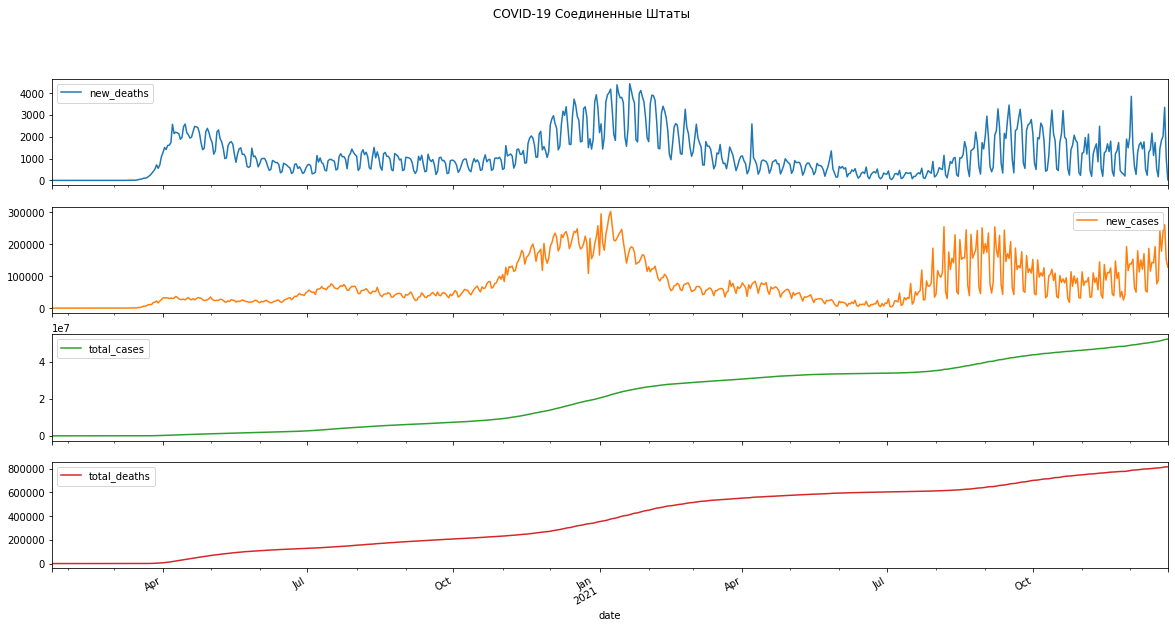

In [21]:
df_new[['new_deaths', 'new_cases', 'total_cases', 'total_deaths']].plot(subplots=True, figsize=(20, 10), title = 'COVID-19 Соединенные Штаты');

#Вывод:
Мы построили общие графики и видно, что как заболеваемость, так и смертность неуклонно растет. Новые случаи заболевания и смертности имеют пики и плато, что объясняется сбором статьстики в вызодные дни. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fde6d0b50>,
      dtype=object)

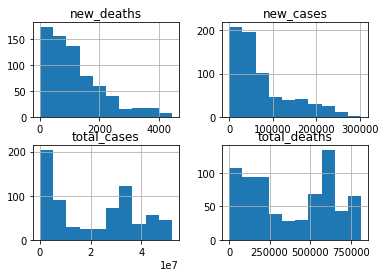

In [22]:
df_new.hist()

#Вывод:
Анализ представленного ненормального распределения позволяет сделать вывод о пиковых нагрузках в период пандемии. На общем графике заболеваемости  2 основных пика, при этом увеличение смертности происходит при снижении пика заболеваемости, что говорит "сдвиге" периода заболевания и продолжительности болезни.

In [23]:
df_new.corr()

,new_deaths,new_cases,total_cases,total_deaths
new_deaths,1.000000,0.703165,0.160516,0.143823
new_cases,0.703165,1.000000,0.349377,0.336478
total_cases,0.160516,0.349377,1.000000,0.993460
total_deaths,0.143823,0.336478,0.993460,1.000000


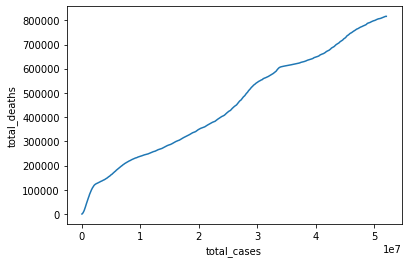

In [24]:
sns.lineplot(data = df_new, x = 'total_cases', y = 'total_deaths')

На графике видна зависимость общего количества смертности от общего количества заболеваемости

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



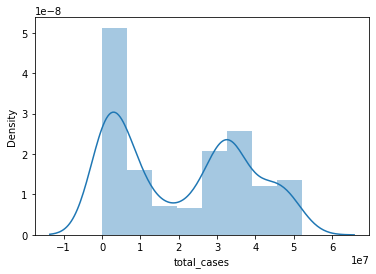

In [25]:
sns.distplot(df_new.total_cases)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



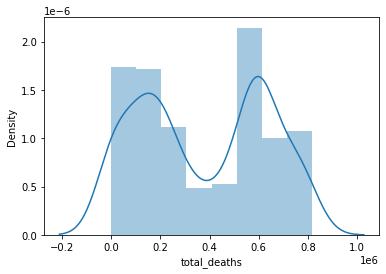

In [26]:
sns.distplot(df_new.total_deaths)

Видим высокий уровень корреляции между кол-вом заболеваний и смертей, что свидетельствует о воздействии сходных факторов на уровень заболеваемости и общей смертности, где на графике видна практически близкая к линейной зависимости этих двух признаков.

Также на графиках KDE видим, что графики распределения подобны, благодаря этому наблюдению можно сформулировать гипотезу исследования:

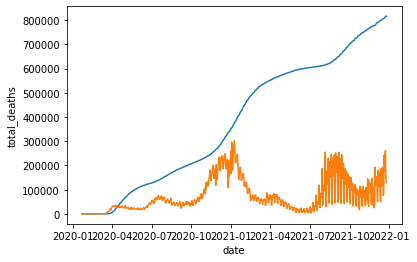

In [27]:
sns.lineplot(data = df_new, x = 'date', y = 'total_deaths')
sns.lineplot(data = df_new, x = 'date', y = 'new_cases')

Мы построили прогнозную модель расчёта новых случаев заражения.

Выделим контрольную и тестовые выборки размером 10 дней:

In [28]:
train = df_new.iloc[:len(df_new)-10]
test = df_new.iloc[len(df_new)-10:]

In [29]:
train.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2020-01-22,United States,2020-01-22,0.0,0.0,1.0,0.0
2020-01-23,United States,2020-01-23,0.0,0.0,1.0,0.0
2020-01-24,United States,2020-01-24,0.0,1.0,2.0,0.0
2020-01-25,United States,2020-01-25,0.0,0.0,2.0,0.0
2020-01-26,United States,2020-01-26,0.0,3.0,5.0,0.0


In [30]:
test.head()

,location,date,new_deaths,new_cases,total_cases,total_deaths
date,,,,,,
2021-12-16,United States,2021-12-16,1146.0,141686.0,50536043.0,804335.0
2021-12-17,United States,2021-12-17,1737.0,192890.0,50728933.0,806072.0
2021-12-18,United States,2021-12-18,511.0,76361.0,50805294.0,806583.0
2021-12-19,United States,2021-12-19,166.0,86727.0,50892021.0,806749.0
2021-12-20,United States,2021-12-20,1452.0,241959.0,51133980.0,808201.0


#ETS декомпозиция

In [31]:
r = seasonal_decompose(df_new['new_cases'],model='additive')

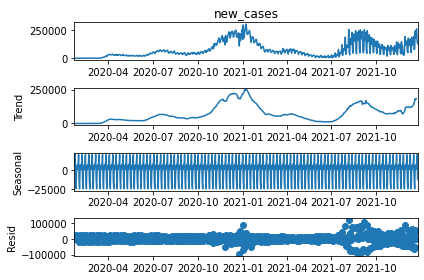

In [32]:
r.plot();

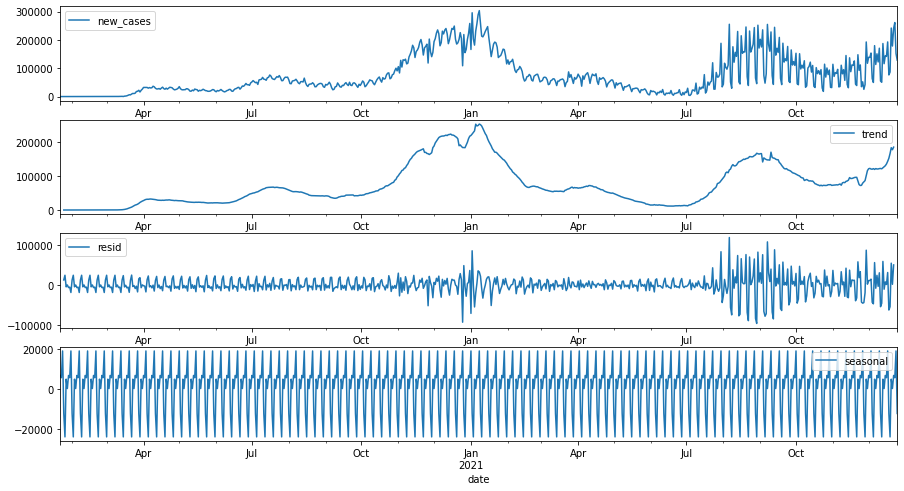

In [33]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
r.observed.plot(ax=ax1, legend=True)
r.trend.plot(ax=ax2, legend=True)
r.resid.plot(ax=ax3, legend=True)
r.seasonal.plot(ax=ax4, legend=True)

#Вывод:
С помощью экспоненциального сглаживания наглядно рассмотрели наши показатели


Построим модели для прогнрзирования данных:

#SARIMAX:
SARIMAX - модель временных рядов, построенная на основе расширенной (eXtended) модели ARIMA с добавлением сезонности (Seasonal).

In [47]:
auto_arima(df_new['new_cases'],seasonal=True, m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  704
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -7978.391
Date:                             Sun, 26 Dec 2021   AIC                          15964.781
Time:                                     08:57:27   BIC                          15983.003
Sample:                                          0   HQIC                         15971.824
                                             - 704                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5198      0.013    -41.166      0.000      -0.545      -0.495
ar.S.L7        0.9530      0.008    114.073      0.000       0.937       0.969
ma.S.L7       -0.4448      0.018    -24.377      0.000      -0.481      -0.409
sigma2      4.248e+08   9.62e-12   4.41e+19      0.000    4.25e+08    4.25e+08
===================================================================================
Ljung-Box (L1) (Q):                  21.13   Jarque-Bera (JB):              9604.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              99.47   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.56e+33. Standard errors may be unstable.
"""

Получилась модель с параметрами SARIMAX(1, 1, 0)x(1, 0, [1], 7)	

Создаем модель с подобранными параметрами и обучаем ее.

In [48]:
model_sarimax = SARIMAX(train['new_cases'],order=(1, 1, 0), seasonal_order=(1, 0, 1, 7))
results_sarimax = model_sarimax.fit()
results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  694
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -7838.658
Date:                             Sun, 26 Dec 2021   AIC                          15685.316
Time:                                     08:57:56   BIC                          15703.480
Sample:                                 01-22-2020   HQIC                         15692.341
                                      - 12-15-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5180      0.012    -44.831      0.000      -0.541      -0.495
ar.S.L7        0.9516      0.008    123.183      0.000       0.936       0.967
ma.S.L7       -0.4411      0.017    -26.439      0.000      -0.474      -0.408
sigma2       3.86e+08   9.12e-12   4.23e+19      0.000    3.86e+08    3.86e+08
===================================================================================
Ljung-Box (L1) (Q):                  22.05   Jarque-Bera (JB):             10209.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              90.58   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.7e+33. Standard errors may be unstable.
"""

предсказываем значения,передав модели results точку начала и окончания

In [49]:
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 0)x(1, 0, [1], 7)	')

Сравниваем прогноз и тестовую выборку

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 9 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 9 missing from current font.



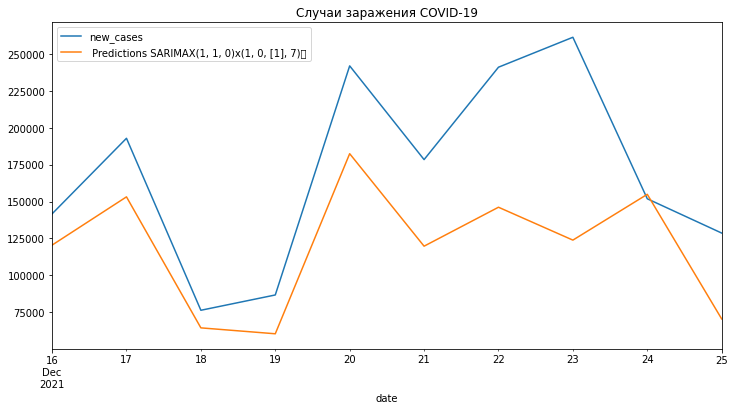

In [50]:
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

Оцениваем качество модели методом MSE, RMSE, MAE, MAPE

In [51]:
mae_error = mean_absolute_error(test['new_cases'], prediction_sarimax)
mse_error = mean_squared_error(test['new_cases'], prediction_sarimax)
rmse_error = rmse(test['new_cases'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['new_cases'])/test['new_cases'])*100
print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAE Error: 51076.22325
SARIMAX(1, 1, 0)x(1, 0, [1], 7) MSE Error: 4.112536579e+09
SARIMAX(1, 1, 0)x(1, 0, [1], 7) RMSE Error: 64129.06189
SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAPE Error: 27.80707218


Делаем прогноз на будущее - 10 дней вперед и обучаем модель на всем датасете

In [52]:
fut_model_sarimax = SARIMAX(df_new['new_cases'],order=(1, 1, 0), seasonal_order=(1, 0, 1, 7))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  704
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -7978.391
Date:                             Sun, 26 Dec 2021   AIC                          15964.781
Time:                                     08:59:17   BIC                          15983.003
Sample:                                 01-22-2020   HQIC                         15971.824
                                      - 12-25-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5198      0.013    -41.166      0.000      -0.545      -0.495
ar.S.L7        0.9530      0.008    114.073      0.000       0.937       0.969
ma.S.L7       -0.4448      0.018    -24.377      0.000      -0.481      -0.409
sigma2      4.248e+08   9.62e-12   4.41e+19      0.000    4.25e+08    4.25e+08
===================================================================================
Ljung-Box (L1) (Q):                  21.13   Jarque-Bera (JB):              9604.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              99.47   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.56e+33. Standard errors may be unstable.
"""

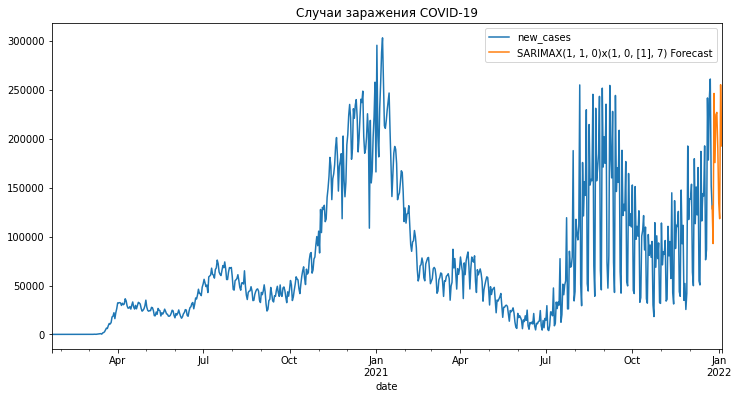

In [53]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df_new)-1,len(df_new)+9,typ='levels').rename('SARIMAX(1, 1, 0)x(1, 0, [1], 7) Forecast')

#строим график на будущее
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

#Выводы:
Временные ряды позволили нам прогнозировать значения. На основании данной модели мы спрогнозировали тенденции в распространении заболевания COVID-19.


#PROFET
Этот метод был разработан для прогнозирования большого числа различных бизнес-показателей и строит достаточно хорошие default'ные прогнозы. Кроме того, библиотека дает возможность, изменяя человеко-понятные параметры, улучшать прогноз и не требует от аналитиков глубоких знаний устройства предсказательных моделей.



In [54]:
# подготовим данные для модели
train_prophet = train[['date','new_cases']]
test_prophet = test[['date','new_cases']]

# Переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] # переименовали столбцы
test_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [55]:
df_new_prophet = df_new[['date','new_cases']]
df_new_prophet.columns = ['ds', 'y'] # переименовали столбцы

In [56]:
model_prophet = Prophet(seasonality_mode='multiplicative')

In [57]:
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Алгоритм проигнорировал, выбирая параметры

Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.

годовую сезонность (для годовой сезонности нам нужно иметь данные минимум за 2 года, чтобы суметь использовать ее в модели)
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

дневную сезонность (дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам).
Зато он обнаружил недельную сезонность и использовал его при настройке модели.

говорим профету сделать дата-фрейм на 10 дней вперед

In [58]:
future_prophet = model_prophet.make_future_dataframe(periods=10)

In [59]:
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() # возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-01-22,-18350.018776,-76359.672114,35638.236623,-18350.018776,-18350.018776,0.095206,0.095206,0.095206,0.095206,0.095206,0.095206,0.0,0.0,0.0,-20097.054537
1,2020-01-23,-17932.052324,-75303.359547,37197.110633,-17932.052324,-17932.052324,0.077207,0.077207,0.077207,0.077207,0.077207,0.077207,0.0,0.0,0.0,-19316.525372
2,2020-01-24,-17514.085871,-74530.333469,38160.384605,-17514.085871,-17514.085871,0.243027,0.243027,0.243027,0.243027,0.243027,0.243027,0.0,0.0,0.0,-21770.490057
3,2020-01-25,-17096.119419,-73999.369592,38400.038098,-17096.119419,-17096.119419,-0.155695,-0.155695,-0.155695,-0.155695,-0.155695,-0.155695,0.0,0.0,0.0,-14434.345870
4,2020-01-26,-16678.152966,-67521.966240,47040.590910,-16678.152966,-16678.152966,-0.327667,-0.327667,-0.327667,-0.327667,-0.327667,-0.327667,0.0,0.0,0.0,-11213.278594


устанавливаем индекс

In [116]:
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-01-22,2020-01-22,-19518.024379,-78648.227471,38522.116890,-19518.024379,-19518.024379,0.094192,0.094192,0.094192,0.094192,0.094192,0.094192,0.0,0.0,0.0,-21356.456682
2020-01-23,2020-01-23,-19088.892710,-81458.842362,40190.960877,-19088.892710,-19088.892710,0.078477,0.078477,0.078477,0.078477,0.078477,0.078477,0.0,0.0,0.0,-20586.929369
2020-01-24,2020-01-24,-18659.761042,-80051.372089,29875.322157,-18659.761042,-18659.761042,0.243236,0.243236,0.243236,0.243236,0.243236,0.243236,0.0,0.0,0.0,-23198.490564
2020-01-25,2020-01-25,-18230.629374,-74208.294026,40901.109960,-18230.629374,-18230.629374,-0.158745,-0.158745,-0.158745,-0.158745,-0.158745,-0.158745,0.0,0.0,0.0,-15336.610447
2020-01-26,2020-01-26,-17801.497706,-73364.070088,45718.839355,-17801.497706,-17801.497706,-0.328266,-0.328266,-0.328266,-0.328266,-0.328266,-0.328266,0.0,0.0,0.0,-11957.866533


In [60]:
prediction_prophet[['ds', 'yhat']]

,ds,yhat
0,2020-01-22,-20097.054537
1,2020-01-23,-19316.525372
2,2020-01-24,-21770.490057
3,2020-01-25,-14434.345870
4,2020-01-26,-11213.278594
...,...,...
699,2021-12-21,122785.056129
700,2021-12-22,134085.440477
701,2021-12-23,132235.383721
702,2021-12-24,152999.226943


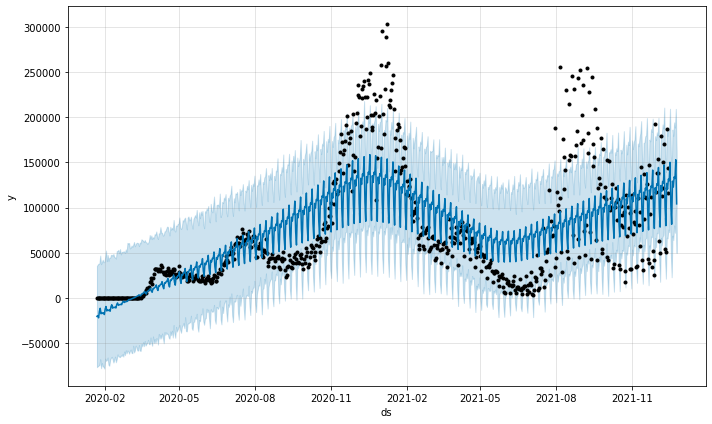

In [61]:
model_prophet.plot(prediction_prophet);

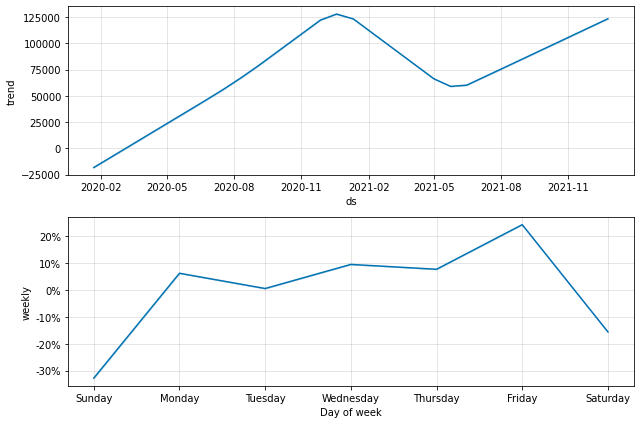

In [62]:
model_prophet.plot_components(prediction_prophet);

In [63]:
mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(10))
rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(10))
mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {mae_error:11.10}')
print(f'Prophet MSE Error: {mse_error:11.10}')
print(f'Prophet RMSE Error: {rmse_error:11.10}')
print(f'Prophet MAPE Error: {mape_error:11.10}')

Prophet MAE Error: 51553.94279
Prophet MSE Error: 4.715242933e+09
Prophet RMSE Error: 68667.62653
Prophet MAPE Error:         nan


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:3522: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects



In [64]:
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_new_prophet)
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=10)
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


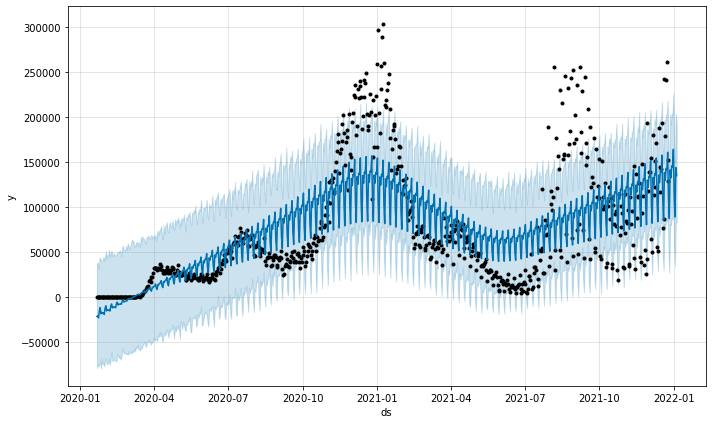

In [65]:
fut_model_prophet.plot(fut_fcast_prophet);

In [66]:
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [67]:
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2020-01-22,2020-01-22,-19847.969801,-79221.795033,37438.556828,-19847.969801,-19847.969801,0.101978,0.101978,0.101978,0.101978,0.101978,0.101978,0.0,0.0,0.0,-21872.025406
2020-01-23,2020-01-23,-19413.853702,-74615.988683,37728.237811,-19413.853702,-19413.853702,0.088824,0.088824,0.088824,0.088824,0.088824,0.088824,0.0,0.0,0.0,-21138.276189
2020-01-24,2020-01-24,-18979.737602,-77699.037752,30111.659412,-18979.737602,-18979.737602,0.235259,0.235259,0.235259,0.235259,0.235259,0.235259,0.0,0.0,0.0,-23444.891091
2020-01-25,2020-01-25,-18545.621502,-74419.635664,42732.177055,-18545.621502,-18545.621502,-0.168925,-0.168925,-0.168925,-0.168925,-0.168925,-0.168925,0.0,0.0,0.0,-15412.811332
2020-01-26,2020-01-26,-18111.505402,-72180.245124,43497.743986,-18111.505402,-18111.505402,-0.335309,-0.335309,-0.335309,-0.335309,-0.335309,-0.335309,0.0,0.0,0.0,-12038.548871


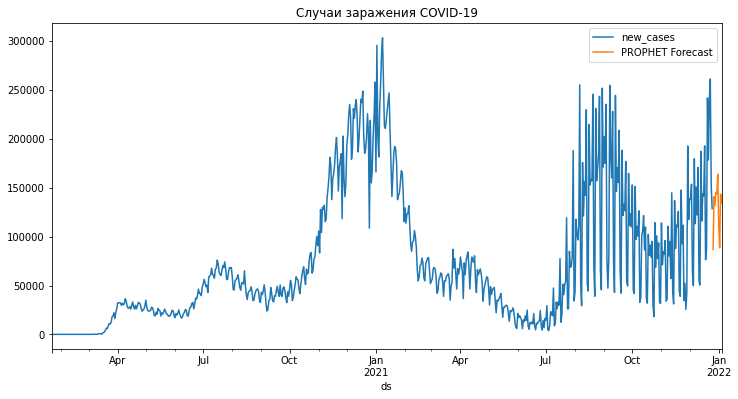

In [68]:
ax = df_new_prophet['y'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_prophet['yhat'].tail(10).plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.legend(["new_cases", "PROPHET Forecast"]);

#Выводы:
Первый график показывает, что пик заболеваний приходится на июнь  и август с выходом на плато.

#Экспоненциальное сглаживание
метод математического преобразования, используемый при прогнозировании временных рядов.
Метод также известен как метод простого экспоненциального сглаживания, или метод Брауна.
Используется в задачах сглаживания и краткосрочного прогнозирования временных рядов.

In [70]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [71]:
model_exps.params

{'damping_trend': nan,
 'initial_level': 0.19999999999999973,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': 0.09090909090909095,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.12285714285714286,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.12285714285714286,
 'use_boxcox': False}

In [72]:
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [73]:
test.index[0]

Timestamp('2021-12-16 00:00:00')

In [74]:
test.index[-1]

Timestamp('2021-12-25 00:00:00')

In [75]:
prediction_exps

array([133006.76221141, 134930.37733375, 136853.99245608, 138777.60757841,
       140701.22270075, 142624.83782308, 144548.45294541, 146472.06806775,
       148395.68319008, 150319.29831241])

In [76]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2021-12-10 00:00:00", periods=10, freq="D")

prediction_exps.columns = ['prediction_exps']

In [77]:
prediction_exps.head()

,prediction_exps
2021-12-10,133006.762211
2021-12-11,134930.377334
2021-12-12,136853.992456
2021-12-13,138777.607578
2021-12-14,140701.222701


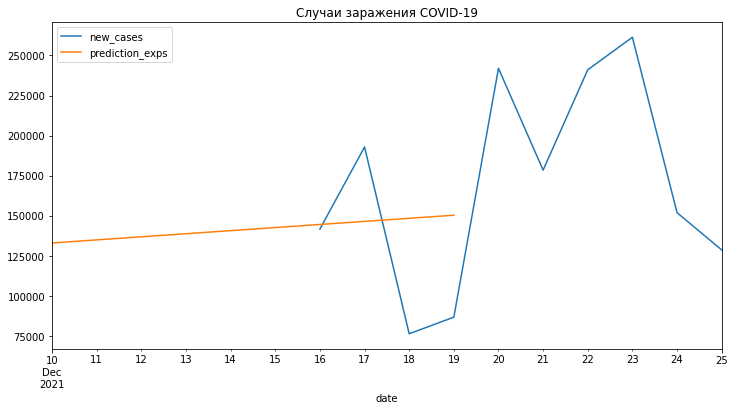

In [78]:
#сравниваем прогноз и тестовую выборку
ax = test['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [80]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['new_cases'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['new_cases'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['new_cases'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['new_cases'])/test['new_cases'])*100

print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAE Error: 55279.74941
SARIMAX(1, 1, 0)x(1, 0, [1], 7) MSE Error: 4.432786621e+09
SARIMAX(1, 1, 0)x(1, 0, [1], 7) RMSE Error: 66579.17558
SARIMAX(1, 1, 0)x(1, 0, [1], 7) MAPE Error: 48.43595246


In [81]:
#делаем прогноз на будущее - 10 дней вперед

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df_new['new_cases'], seasonal_periods=7, trend = 'add')# недельная сезонность
fut_model_exps.fit()

#задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df_new)-1, end=len(df_new)+9)

#преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("2021-12-19", periods=11, freq="D")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [83]:
fut_fcast_exps.head()

,fut_fcast_exps
2021-12-19,188904.253204
2021-12-20,185811.599406
2021-12-21,190118.416717
2021-12-22,194425.234027
2021-12-23,198732.051337


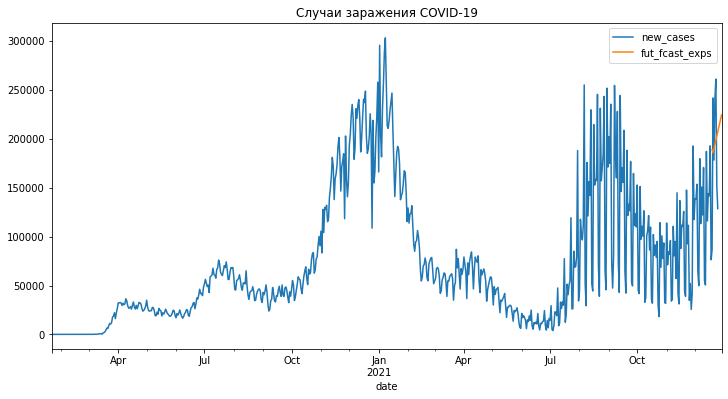

In [84]:
ax = df_new['new_cases'].plot(legend=True, figsize=(12,6),title='Случаи заражения COVID-19') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

#Выводы:
Мы рассмотрели самые распространенные методы прогнозирования временных рядов: Экспоненциальное сглаживание Хольта-Винтерса, SARIMA, Prophet и проведение экспериментов на временном ряде Covid-19 с ежедневными данными. Эксперимент проводился с помощью языка Python.
Для прогнозирования использовалась библиотека pmdarima и fbprophet.
Самой точной моделью в нашем случае будет SARIMAX
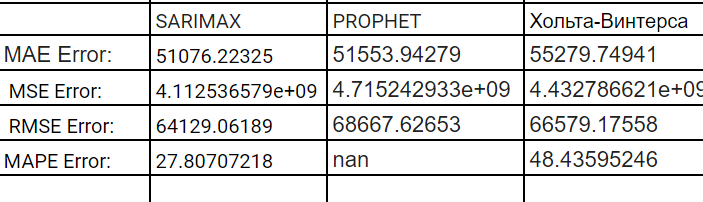
				

			
